In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Example of the linear congruent method

Here we show a particularly bad version of the linear congruent method.

In [8]:
nrandom = 10
x = np.zeros(nrandom, dtype=np.int32)
M = np.int32(256)
c = np.int32(3)
a = np.int32(5)

In [9]:
x[0] = 15
for indx in np.arange(nrandom - 1):
   x[indx + 1] = (x[indx] * a + c) % M
   print(x[indx + 1])

78
137
176
115
66
77
132
151
246


In [10]:
nrandom = 10000
x = np.zeros(nrandom, dtype=np.int32)
x[0] = 15
for indx in np.arange(nrandom - 1):
   x[indx + 1] = (x[indx] * a + c) % M

If we look at the histogram of values between 0 and 255, it is fairly uniform.

(array([ 1017.,   975.,  1015.,   977.,  1018.,   978.,  1015.,   975.,
         1015.,  1015.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

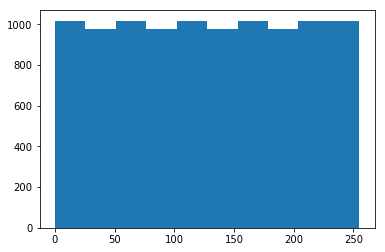

In [14]:
plt.hist(x)

But a definite pattern is noticable when you just plot the numbers!

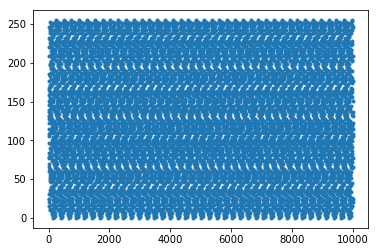

In [19]:
plt.plot(x, '.')

When you compare one number to its neighbor, there is a very definite pattern! These are not random at all!!

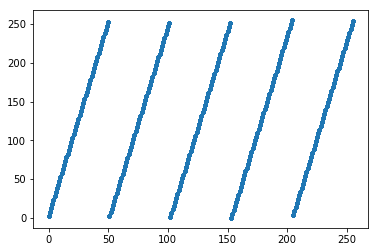

In [18]:
plt.plot(x[0:-2], x[1:-1], '.')

In [20]:
np.histogram?